# Evaluating MAGIC with Synthetic Dataset

[MAGIC](https://github.com/KrishnaswamyLab/MAGIC) is an imputation tool developed at the [Broad Institute](https://www.broadinstitute.org) for single cell RNA-sequencing (scNRA-seq) data. Imputation can potentially help improve downstream analysis in scRNA-seq data pipelines due to the potential of denoising the high dropout rates (errerroneously observed 0s) that currently obscure gene-gene relationships. Despite this promise, MAGIC has failed to receive universal support on whether it successfully recuperates lost information. This is an attempt to discover the effects of MAGIC on a synthetic dataset to determine whether its claims holds true for a simple test case.

In [1]:
#imports

In [2]:
import magic
import pandas as pd 
import seaborn as sns
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scanpy.external as sce
from numpy.random import seed
from numpy.random import normal
from random import sample
from random import choices
from scipy.stats import rv_discrete, rv_continuous
from scipy.stats import nbinom

pd.set_option('display.max_rows', None)

In [3]:
#functions

In [4]:
seed(1738)
def create_synthetic_cells(rna_species_char, p, number_cells=100):
    '''
    Inputs
    --------
    p: the probability of a single success (parameter to scipy.stats.nbinom)
    rna_species_char: List of size N representing the profile of N RNA species
    number_cells: number of cells (rows) in synthetic dataset
    
    Sampling using a negative binomial distribution where n = # of median RNA
    
    Outputs
    --------
    Pandas dataframe of size (number_cells x N) where each row represents a cell
    sampled from rna_species_char.
    '''
    cell_generator = [nbinom(n, p) for n in rna_species_char]
    df = pd.DataFrame([dist.rvs(number_cells) for dist in cell_generator]).T
    df = df.set_axis([f"Gene {g + 1}" for g in range(len(df.columns))], axis=1, inplace=False)
    return df

sim_capture = lambda x, p: sum(choices([0, 1], weights=[1-p, p])[0] for _ in range(x))

def artificially_sample_cells(true_cells_df, capture_rate):
    '''
    Simulating Bernoulli sampling with synthetic dataset 
    where p = capture_rate (p := probability RNA is included in set)
    '''
    return true_cells_df.applymap(lambda x: sim_capture(x, p=capture_rate))

def ready_for_plot():
    merfish_repr["Model"] = "MERFISH"
    tenx_repr["Model"] = "10X synthetic"
    return pd.concat([merfish_repr, tenx_repr])

def rescale_data(data, target_data, rescale):
    '''
    Function from older version of MAGIC to rescale after imputation
    '''
    if rescale == 0:
        return data
    else:
        data[data < 0] = 0
        M99 = np.percentile(target_data, rescale, axis=0)
        M100 = target_data.max(axis=0)
        indices = np.where(M99 == 0)[0]
        M99[indices] = M100[indices]
        M99_new = np.percentile(data, rescale, axis=0)
        M100_new = data.max(axis=0)
        indices = np.where(M99_new == 0)[0]
        M99_new[indices] = M100_new[indices]
        max_ratio = np.divide(M99, M99_new)
        data = np.multiply(data, np.tile(max_ratio,
                                      (target_data.shape[0], 1)))
    return data

## 1. Generating Synthetic Dataset

### 1.1: Intro to MERFISH & 10x scRNA-seq

Two popular methods for measuring RNA species post-mortem are: [MERFISH](https://www.science.org/doi/10.1126/science.aaa6090) & [10x scRNA-seq](https://www.10xgenomics.com/blog/single-cell-rna-seq-an-introductory-overview-and-tools-for-getting-started). Both these methods are able to identify which cells within a tissue sample a given mRNA molecule comes from. Besides MERFISH being a fluorescent approach and 10x scRNA-seq utilizes sequencing, they differ in their capture rates and number of observed RNA species. MERFISH is limited by the visual spectrum, thus, can only observe an order of ~100 RNA species but with a capture rate of ~90% (fraction of RNA transcripts observerd within the ~100 RNA species). Meanwhile, 10x scRNA-seq is not bound by the observed RNA species but observe mRNA with a [much lower capture rate of 30-32%](https://kb.10xgenomics.com/hc/en-us/articles/360001539051-What-fraction-of-mRNA-transcripts-are-captured-per-cell-).

### 1.2: Generating synthetic cells and simulating both MERFISH & 10x scRNA-seq

Sampling using a negative binomial distribution for the cells we will determine as the ground truth. Then, simulating both MERFISH & 10x scRNA-seq as a Bernoulli process with the capture rate serving as the probability of a success.

In [5]:
Rna_species_characteristic_numbers = [1, 3, 10, 30, 100, 300, 1000, 3000, 10000]

synth_cells = create_synthetic_cells(Rna_species_characteristic_numbers, p=0.5)
merfish_original_synth = artificially_sample_cells(synth_cells, 0.9)
tenx_original_synth = artificially_sample_cells(synth_cells, 0.3)

synth_cells["Model"] = "Ground Truth"
merfish_original_synth["Model"] = "MERFISH"
tenx_original_synth["Model"] = "10x scRNA-seq"

### 1.3: Data
#### Peeking at the data:

##### Synthetic Data:

In [6]:
synth_cells

,Gene 1,Gene 2,Gene 3,Gene 4,Gene 5,Gene 6,Gene 7,Gene 8,Gene 9,Model
0,1,3,8,30,121,295,940,2987,10138,Ground Truth
1,2,3,5,21,116,296,1002,2970,10366,Ground Truth
2,8,1,17,18,133,320,1031,3073,9983,Ground Truth
3,0,2,8,29,118,320,983,2861,9927,Ground Truth
4,7,2,8,30,85,290,1056,2982,9959,Ground Truth
5,2,3,16,37,104,309,997,2895,10034,Ground Truth
6,0,0,8,33,78,330,1068,3098,10097,Ground Truth
7,2,5,8,25,102,322,1050,3028,9973,Ground Truth
8,0,0,9,30,99,319,1038,2956,9895,Ground Truth
9,4,2,13,24,127,303,1040,2914,9986,Ground Truth


##### MERFISH data:

In [7]:
merfish_original_synth

,Gene 1,Gene 2,Gene 3,Gene 4,Gene 5,Gene 6,Gene 7,Gene 8,Gene 9,Model
0,1,2,7,29,109,269,841,2685,9136,MERFISH
1,1,2,5,18,99,274,898,2657,9322,MERFISH
2,7,1,14,15,118,292,925,2765,8957,MERFISH
3,0,2,7,26,98,291,887,2553,8926,MERFISH
4,6,2,8,27,73,263,944,2712,8978,MERFISH
5,1,2,16,33,95,276,915,2622,9055,MERFISH
6,0,0,7,27,68,292,959,2807,9105,MERFISH
7,2,4,7,20,94,286,942,2709,8977,MERFISH
8,0,0,9,26,89,280,932,2640,8870,MERFISH
9,3,2,11,23,117,268,941,2610,9041,MERFISH


##### 10x scRNA-seq data:

In [8]:
tenx_original_synth

,Gene 1,Gene 2,Gene 3,Gene 4,Gene 5,Gene 6,Gene 7,Gene 8,Gene 9,Model
0,0,0,0,10,32,93,288,901,2994,10x scRNA-seq
1,0,0,3,6,40,80,316,930,3174,10x scRNA-seq
2,2,0,2,6,32,109,295,957,3051,10x scRNA-seq
3,0,1,2,9,35,97,317,881,2988,10x scRNA-seq
4,0,0,2,6,24,72,316,872,2982,10x scRNA-seq
5,1,0,6,15,31,114,303,851,2951,10x scRNA-seq
6,0,0,3,11,20,107,297,909,3068,10x scRNA-seq
7,1,0,3,7,24,94,318,897,2976,10x scRNA-seq
8,0,0,1,11,29,111,325,892,2953,10x scRNA-seq
9,1,0,1,6,34,73,294,895,3062,10x scRNA-seq


#### Plotting data:

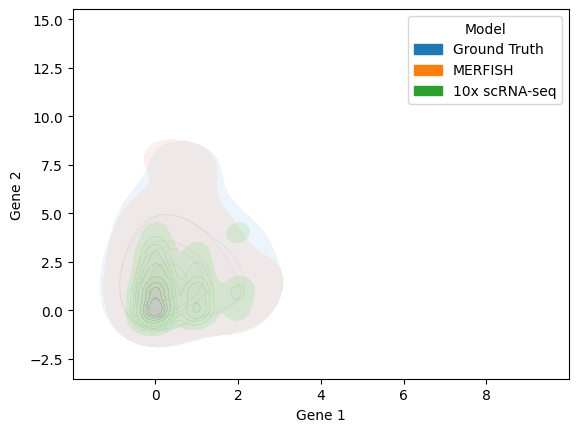

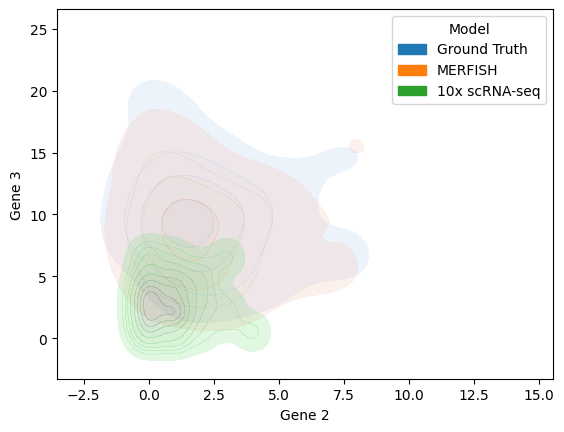

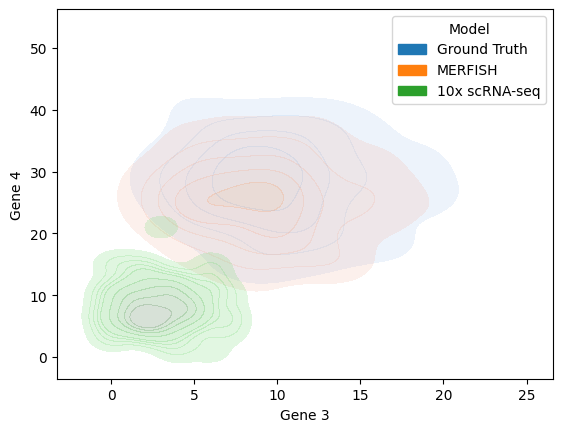

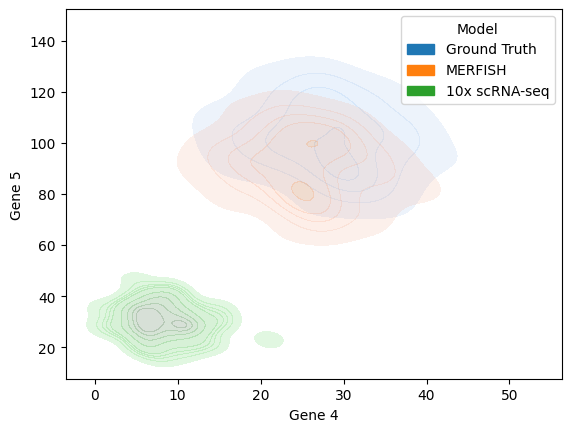

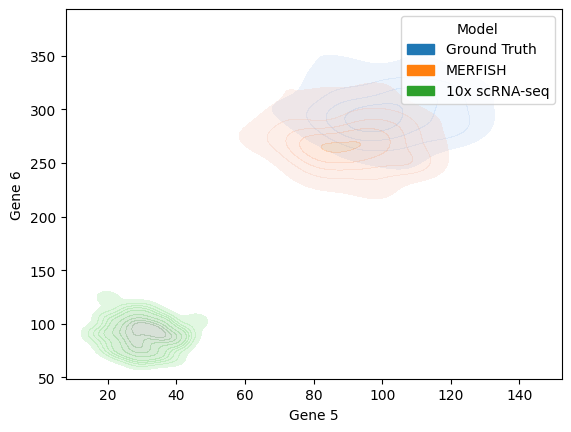

In [9]:
before_imputation = pd.concat([synth_cells, merfish_original_synth, tenx_original_synth], ignore_index=True)
genes = before_imputation.columns[:-1]

for i in range(5): 
    plt.figure() #this creates a new figure on which your plot will appear
    sns.kdeplot(data=before_imputation, x=genes[i], y =genes[i+1], hue="Model", alpha=0.2, fill=True)

From the plots, we can see that the MERFISH distributions more closely resemble that of the Ground Truth dataset. Thus, our goal with imputation is to transform the 10x scRNA-seq data to become more similar to the MERFISH data.

## 2. Imputation

### 2.1: Normalization

Normalizing the RNA counts as a processing step for MAGIC. Using the MERFISH as basis for normalized sum to compare downstream. Before MAGIC, the 10x scRNA-seq data is normalized by the median RNA count of the dataset, then the values are square rooted.

In [10]:
merfish_original_synth = merfish_original_synth.drop(columns=["Model"])
tenx_original_synth = tenx_original_synth.drop(columns=["Model"])

# obtaining target sum for normalization
merfish_rna_counts = merfish_original_synth.sum(axis=1)
normalized_sum = int(merfish_rna_counts.median())

# Normalizing dataset
merfish_repr = sc.AnnData(merfish_original_synth)
tenx_repr = sc.AnnData(tenx_original_synth)

sc.pp.normalize_total(merfish_repr, target_sum=normalized_sum)
tenx_norm = tenx_repr.copy()
sc.pp.normalize_total(tenx_norm, target_sum=normalized_sum)

# Pre-processing step for MAGIC
sc.pp.normalize_total(tenx_repr)
tenx_raw = tenx_repr.to_df() # use later for rescaling
sc.pp.sqrt(tenx_repr)

/tmp/ipykernel_1958/1306700857.py:9: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  merfish_repr = sc.AnnData(merfish_original_synth)
/opt/hostedtoolcache/Python/3.8.15/x64/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_1958/1306700857.py:10: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tenx_repr = sc.AnnData(tenx_original_synth)


### 2.2: Running MAGIC

Running MAGIC with default parameters and normalizing the imputed counts back to the basis of the MERFISH median by squaring and normalizing sum.

In [11]:
sce.pp.magic(tenx_repr, name_list='all_genes', solver='exact', n_jobs=-1)
tenx_repr.X = tenx_repr.X**2

/opt/hostedtoolcache/Python/3.8.15/x64/lib/python3.8/site-packages/magic/utils.py:145: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  data = anndata.AnnData(data)


### 2.3: Rescaling Imputed Counts

Duplicating the results of MAGIC to determine whether rescaling after imputation is still necessary. Using a vestigial function ```rescale_data()``` from the [Krishnaswamy Lab](https://github.com/KrishnaswamyLab).

In [12]:
tenx_rescaled_norm = tenx_repr.copy()
imputed_rescaled_df = tenx_rescaled_norm.to_df()
imputed_rescaled_df = rescale_data(imputed_rescaled_df, tenx_raw, 99)
imputed_rescaled = sc.AnnData(imputed_rescaled_df)

/tmp/ipykernel_1958/2028333819.py:4: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  imputed_rescaled = sc.AnnData(imputed_rescaled_df)


Here, we are re-normalizing the both the impute counts with and without rescaling to the previously used target sum.

In [13]:
sc.pp.normalize_total(tenx_repr, target_sum=normalized_sum)
sc.pp.normalize_total(imputed_rescaled, target_sum=normalized_sum)

imputed_df = tenx_repr.to_df()
imputed_rescaled_df = imputed_rescaled.to_df()
merfish_df = merfish_repr.to_df()
tenx_norm_df = tenx_norm.to_df()

imputed_df["Model"] = "10x scRNA-seq Imputed"
imputed_rescaled_df["Model"] = "10x Imputed Rescaled"
tenx_norm_df["Model"] = "10x scRNA-seq"
merfish_df["Model"] = "MERFISH Normalized"
synth_cells["Model"] = "True cells"

after_imputation = pd.concat([imputed_rescaled_df,merfish_df, tenx_norm_df, synth_cells], ignore_index=True)

## 3. Results after Imputation

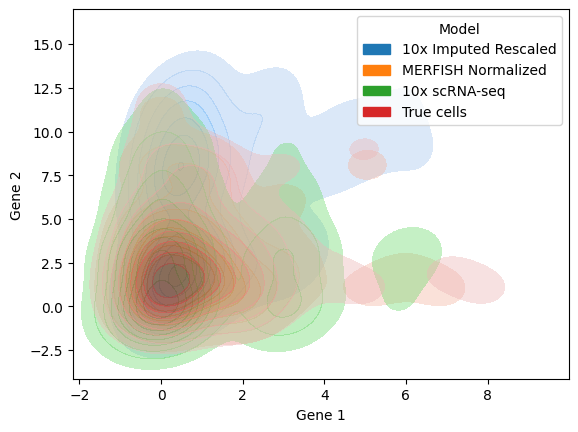

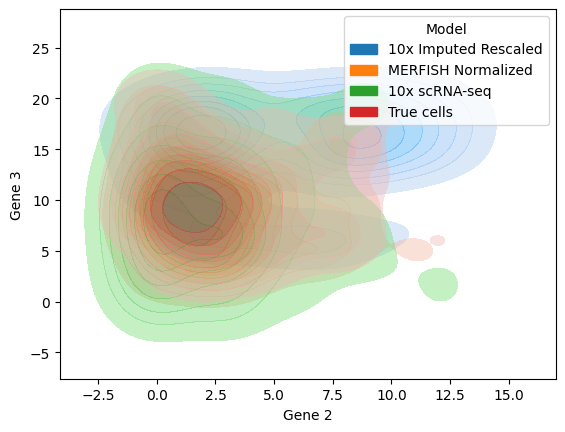

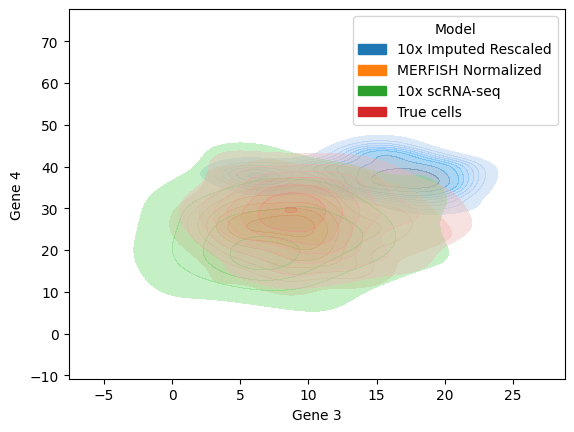

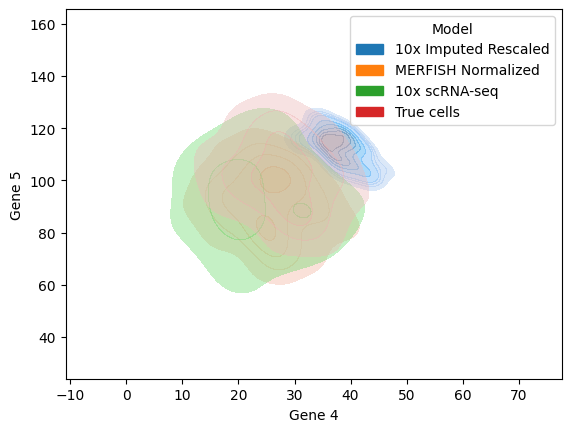

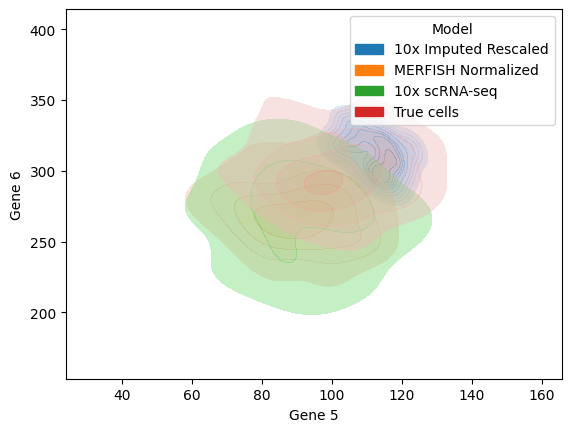

In [14]:
for i in range(5): 
    plt.figure()
    sns.kdeplot(data=after_imputation, x=genes[i], y =genes[i+1], hue="Model", alpha=0.4, fill=True)

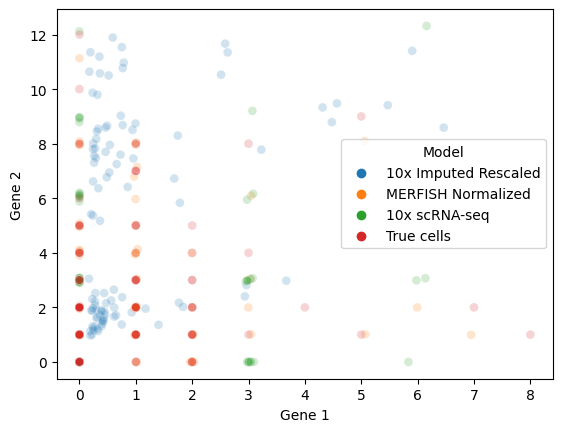

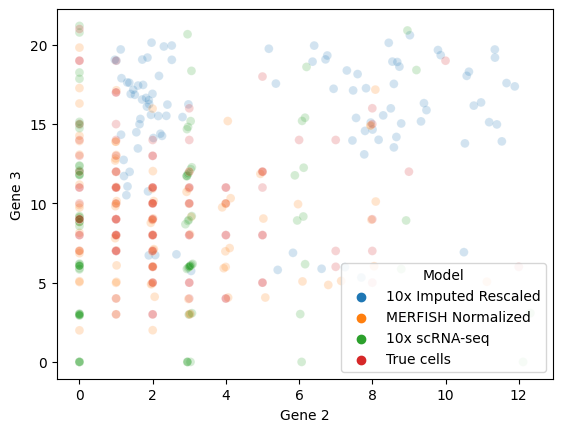

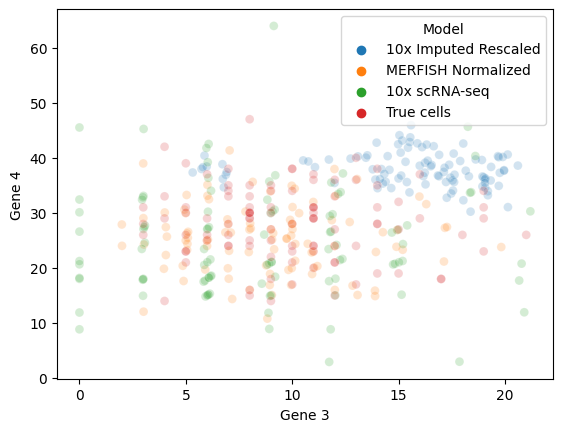

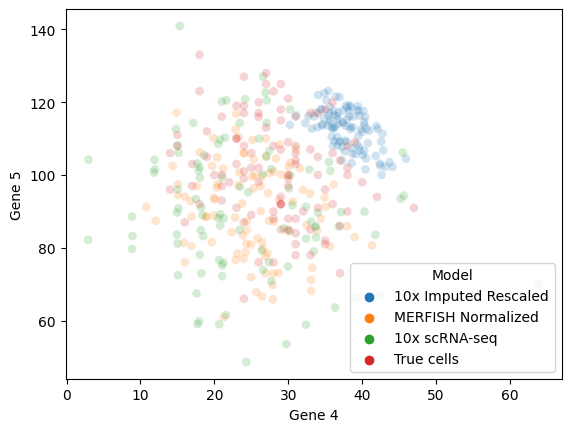

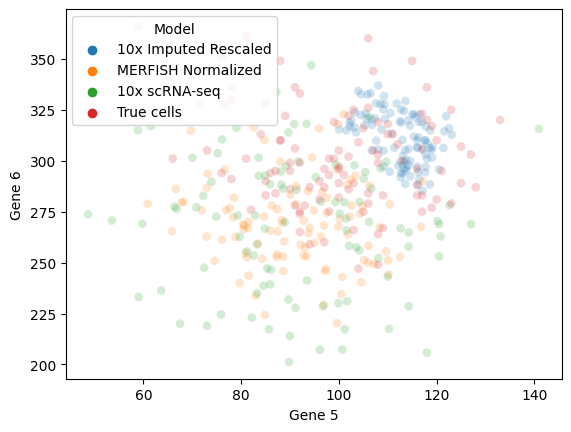

In [15]:
for i in range(5): 
    plt.figure()
    sns.scatterplot(data=after_imputation, x=genes[i], y =genes[i+1], hue="Model", alpha=0.2, s=40)

Thinking of including a metric to evaluate the performance of imputation. I could also write another blog post about the metric.